# Data preprocessing

In [6]:
!rm -rf dataset
!rm -rf CELEB-A

In [7]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!echo '{"username":"rajatkb","key":"788b38e5627381e531e87b985063c0d0"}' > ~/.kaggle/kaggle.json

In [9]:
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [10]:
!kaggle datasets list -s {CelebA}

ref                                                   title                                        size  lastUpdated          downloadCount  
----------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  
jessicali9530/celeba-dataset                          CelebFaces Attributes (CelebA) Dataset        1GB  2018-06-01 20:08:48          46668  
zuozhaorui/celeba                                     celeba                                        3GB  2018-11-03 05:29:21            364  
ashishjangra27/gender-recognition-200k-images-celeba  Gender Classification 200K Images | CelebA    1GB  2020-05-22 20:15:23            542  
ruchi798/periocular-detection                         Periocular Recognition                       13MB  2020-08-09 00:45:00            175  
lamsimon/celebahq                                     celeba-hq                                     3GB  2020-07-28 14:46:35            239  
tannys

In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/kaggle/

 98% 1.31G/1.33G [00:10<00:00, 159MB/s]
100% 1.33G/1.33G [00:10<00:00, 138MB/s]


In [12]:
!unzip /content/kaggle/celeba-dataset.zip -d CELEB-A

Streaming output truncated to the last 5000 lines.
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: CELEB-A/img_align_celeba/img_align_celeba/197617.jpg

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2


In [14]:
IMAGE_LOCATION = '/content/CELEB-A/img_align_celeba/img_align_celeba'
CSV_LOCATION = '/content/CELEB-A/list_attr_celeba.csv'

# Dataset Parse

In [15]:
class ParseCelebA:
    def __init__(self , 
                 CSV_LOCATION = '/content/CELEB-A/list_attr_celeba.csv' , IMAGE_LOCATION =  '/content/CELEB-A/img_align_celeba/img_align_celeba' ,  
                 attr =  ['image_id' , 'Arched_Eyebrows' , 
                          'Bags_Under_Eyes' , 'Bald' , 'Big_Lips' ,
                          'Big_Nose',	'Black_Hair'	, 'Blond_Hair' , 
                          'Brown_Hair' , 	'Chubby',	'Double_Chin',	
                          'Eyeglasses',	'Goatee'	,'Gray_Hair' , 'Male' , 
                          'Mustache' , 'No_Beard' , 'Smiling' , 'Young' ]
                 ):
        csv = pd.read_csv(CSV_LOCATION, low_memory= False)
        index2attr = attr[1:]
        attr2index = dict( [(index2attr[i] , i ) for i in range(len(index2attr))] )
        ncsv = csv[attr]
        ncsv = ncsv.replace(to_replace=-1 , value = 0)

        self.index2attr = index2attr
        self.attr2index = attr2index
        self.df = ncsv
        self.dataset =  lambda : map(lambda x: (os.path.join(IMAGE_LOCATION ,  x[1]) , np.array(x[2:]).astype(np.float32)  ) , ncsv.sample(frac=1).itertuples())
        self.count =  ncsv['image_id'].count()
        print('total entries: ' , ncsv['image_id'].count())

    def get_rows(self):
        return self.dataset()

    def get_total_attributes(self):
        return len(self.index2attr)

    def get_iterations(self , batch_size):
        return  int(self.count / batch_size)

    def batched(self , batch_size = 64 , size = 512 , preprocess = [lambda x: x]):
        
        for mem_batch in self.dataset_batch(size , preprocess):
            image , label = mem_batch
            mem_size = len(image)
            it = int(mem_size / batch_size)
            for i in range(it):
                img = image[i*batch_size : (i+1)*batch_size]
                attr = label[i*batch_size : (i+1)*batch_size]
                if len(img) == 0:
                    continue
                yield (img , attr)
            
            img = image[(i+1)*batch_size:]
            attr = label[(i+1)*batch_size:]
            if len(img) == 0:
                continue
            yield (img , attr)


    def dataset_batch(self , size = 512 , preprocess = [lambda x: x]):
        image_batch = []
        attr_batch = []
        for sample in self.get_rows():
            image_loc , label = sample
            image = Image.open(image_loc)
            image = np.array(image)
           
            for p in preprocess:
                  image = p(image)

            image = image.astype(np.float32)
            label = label.astype(np.float32)

            image_batch.append(image)
            attr_batch.append(label)


            if len(image_batch) == size:
                
                yield ( np.array(image_batch).astype(np.float32) , np.array(attr_batch).astype(np.float32))
                image_batch = []
                attr_batch = []

        if len(image_batch) > 0:
            yield ( np.array(image_batch).astype(np.float32) , np.array(attr_batch).astype(np.float32))

    def decode_labels(self, labels):
        lb = []
        for i in range(len(labels)):
            if labels[i] == 1:
                lb.append(self.index2attr[i])
        return lb

In [16]:
## Test
parseData = ParseCelebA()
parseData.get_iterations(32)

total entries:  202599


6331

In [17]:
parseData.df.head()

,image_id,Arched_Eyebrows,Bags_Under_Eyes,Bald,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Male,Mustache,No_Beard,Smiling,Young
0,000001.jpg,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1
1,000002.jpg,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1
2,000003.jpg,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,000004.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,000005.jpg,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## Preprocess 

In [18]:

def resize(size):
    return lambda image:   cv2.resize(image, size,  interpolation = cv2.INTER_LINEAR)

def standardize(image):
    image = ((image - 127.5) / 127.5)
    return image

def clip_image(low , max):
    return lambda image : np.clip(image, low, max)



## Deprocess

In [19]:
def undo_standardize(image):
    image = ((image * (127.5)) + 127.5)
    return image

In [20]:

# next(parseData.batched( batch_size = 64 , size = 512 , preprocess= [
#       resize((128 , 128)) ,standardize ,clip_image                                                 
# ] ))[0].shape

# Visualize Data

In [21]:
## Utility function to see one image sample
def seeOne(data , index2attr):
    image = None
    if type(data[0]) == "str": 
        image = Image.open(data[0])
        image = np.array(image)
    else:
        image = data[0]
    
    plt.imshow(image)
    labels = []
    for i in range(len(data[1])):
        if data[1][i] == 1:
            labels.append(index2attr[i])
    plt.title(label = '{} features'.format('\n'.join(labels)))
    plt.show()

In [22]:
def seeFew(data , index2attr):
    count = len(data)
    gl = int(np.sqrt(count))
    gw = int(count / gl)
    fig = plt.figure(figsize = (count+10 , count+10))
    for i in range(1, count+1):
      index = i
      labels = []
      img , label = data[index-1]
      for m in range(len(label)):
          if label[m] == 1:
              labels.append(index2attr[m])
      plt.subplot(gl , gw , index , title = '{} : features'.format(', '.join(labels)))
      plt.imshow(img)
    return fig

## Inference and Visualization

In [23]:
# # create summary writer
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)

# # inside training loop
# with train_summary_writer.as_default():
# 	# for normal data
# 	tf.summary.scalar('loss', train_loss, step=step_no) # step number as in x - axis
# 	# for image data
# 	tf.summary.image('figure_1', tensor, step=step_no)
# 	train_summary_writer.flush()

In [129]:
def make_plot(n_imgs=4):
    
    plfig = plt.figure(figsize=(7,5))
    imfig = plt.figure(constrained_layout=True, figsize=(7,4))
    
    plplot = plfig.add_subplot(221)
    l1plot = plfig.add_subplot(222)
    gvdplot = plfig.add_subplot(224)
    atplot = plfig.add_subplot(223)
    
    imgplot = []
    for n in range(n_imgs):
      imgplot.append(imfig.add_subplot(1, n_imgs, n+1))
    
    hdisplay = display(display_id=True)
    idisplay = display(display_id=True)
    loss_dict = { 'l1' : [], 'pl' : [], 'at' : [], 'dal' : [], 'gal': [] }


    def __inner(losses, out_imgs, lbl_list):
        nonlocal loss_dict


        l_l1, l_p, l_ga, l_dad, l_gad = losses
        

        loss_dict['l1'].append(l_l1)
        loss_dict['pl'].append(l_p)
        loss_dict['at'].append(l_ga)
        loss_dict['dal'].append(l_dad)
        loss_dict['gal'].append(l_gad)

        #fig.suptitle('showing keypoint #' + str(idx+1))
        plplot.cla()
        l1plot.cla()
        gvdplot.cla()
        atplot.cla()
        
        for inner_list in loss_dict.values():
          if len(inner_list) > 300:
            loss_list = loss_list[-300:]
        
        plplot.set_ylabel('Perceptual Loss')
        l1plot.set_ylabel('L1 loss')
        gvdplot.set_ylabel('G vs. D loss')
        atplot.set_ylabel('Attribute loss')
        # atplot.set_xlabel('no. of batches')

        plplot.plot(loss_dict['pl'], 'b-')
        l1plot.plot(loss_dict['l1'], 'b-')
        gvdplot.plot(loss_dict['dal'], 'b-', label="D")
        gvdplot.plot(loss_dict['gal'], 'r-', label="G")
        atplot.plot(loss_dict['at'], 'b-')

        for i in range(n_imgs):
          imgplot[i].imshow(out_imgs[i])
          imgplot[i].set_xlabel('features:\n{}'.format('\n'.join(str(feat) for feat in lbl_list[i])))
          imgplot[i].set_xticks([])
          imgplot[i].set_yticks([])

        gvdplot.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)

        plfig.tight_layout()
        
        hdisplay.update(plfig)
        idisplay.update(imfig)
    return __inner

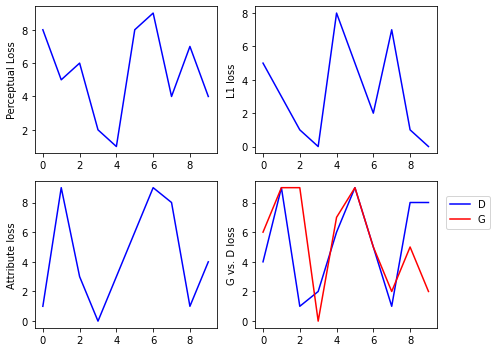

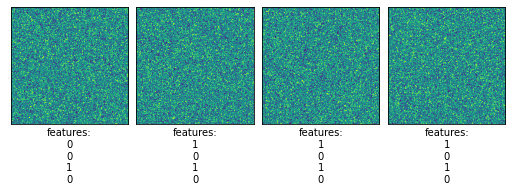

In [26]:
update_plot = make_plot()

for i in range(10):
  dummy = np.random.randint(low=0, high=10, size=(5,))
  dummy_img = []
  lbls = []
  for i in range(4):
    dummy_img.append(np.random.rand(200, 200))
    lbls.append(np.random.randint(low=0, high=2, size=(4,)))
  update_plot(dummy, dummy_img, lbls)

plt.close('all')

## Visualise Dataset

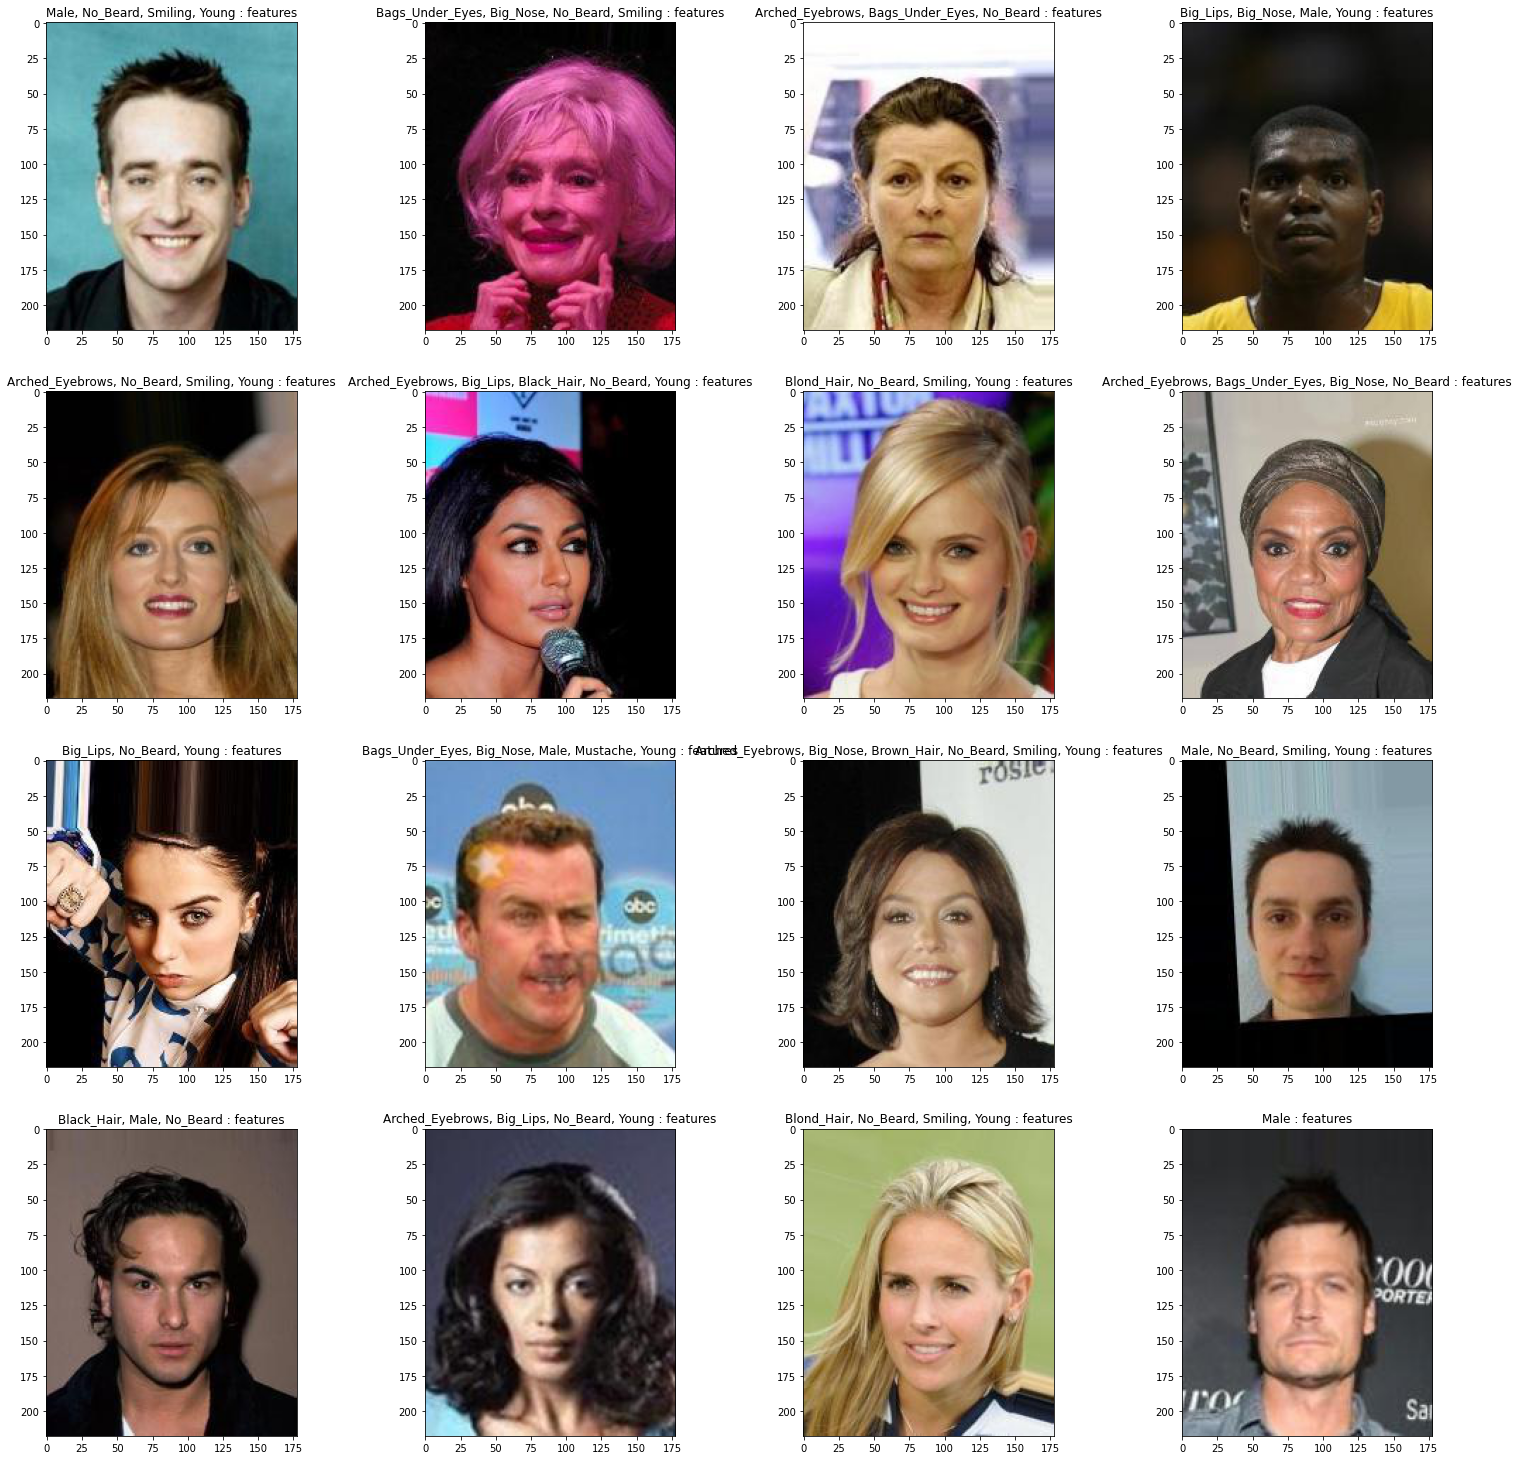

In [ ]:
import itertools
data = map(lambda data: ( np.array(Image.open(data[0])) , data[1]) ,  parseData.get_rows())
data = list(itertools.islice(data , 16))
fig = seeFew(data , parseData.index2attr)

# Functional Blocks

## SSC Block implementation

In [27]:
# module imports
import tensorflow as tf
import numpy as np
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import tensorflow.keras.backend as k 
from tensorflow.keras import Model

In [28]:
class StyleFeature(keras.layers.Layer):
      def __init__(self , **kwargs):
          '''
            Builds style feature
          '''
          super(StyleFeature , self).__init__(**kwargs)
          pass
      def call(self , input):
          (_ , h , w , c) = k.int_shape(input)
          out = Reshape((-1 , c))(input)
          mean = k.mean(out , axis = -2)
          std = k.std(out , axis = -2)
          out = Concatenate()([mean, std])
          return out

class SSCFeature(keras.layers.Layer):
      def __init__(self, activation='relu',use_bias=True ,kernel_initializer='glorot_uniform', **kwargs):
          '''
            Build the SSC Feature 
          '''
          super(SSCFeature , self).__init__(**kwargs)
          self.activation = activation
          self.use_bias = use_bias
          self.kernel_initializer = kernel_initializer
          self.style_op = StyleFeature(name='style_feature'+self.name) # TO ASK
          self.dense1 = None
          self.dense2 = None

      def call(self , inputs):
          input_conv_feature , input_attribute_diff = inputs # to ask
          (_ , h , w , c) = k.int_shape(input_conv_feature)
          (_ , _) = k.int_shape(input_attribute_diff)
          style_feature = self.style_op(input_conv_feature)
          out = Concatenate()([input_attribute_diff , style_feature])

          if self.dense1 is None:
              self.dense1 =  Dense(2*c , activation=self.activation , use_bias=self.use_bias , kernel_initializer=self.kernel_initializer , name='dense1_'+self.name)
          if self.dense2 is None:
              self.dense2 = Dense(2*c , activation=self.activation , use_bias=self.use_bias , kernel_initializer=self.kernel_initializer , name='dense2_'+self.name)
          
          out = self.dense1(self.dense2(out))
          out = Add()([out , style_feature])
          return out

class AdaptiveInstanceNormalization(keras.layers.Layer):
      def __init__(self , feature_extractor = None , **kwargs):
          '''
            Build modified AdaIN with calculated features as mean and variance
          '''
          super(AdaptiveInstanceNormalization , self).__init__(**kwargs)
          self.feature_extractor = feature_extractor
          pass

      def half_channel(self, x , c):
          mean = Lambda(lambda x_: x_[..., 0:int(c/2)], output_shape=(int(c/2)) )(x)
          std = Lambda(lambda x_: x_[..., int(c/2):], output_shape=(int(c/2)) )(x)
          return mean,std

      def call(self , inputs):
          '''
            ( enc_ssc_feature , dec_style_feature) = inputs
            enc_ssc_feature : the feature transformation to be applied on the decoder feature -> (_ , c)
            dec_style_feature : the decoder style feature -> (_ , c)
          '''
          ssc_feature , dec_conv = inputs
          dec_feature = self.feature_extractor(dec_conv)
          (_ , c) = k.int_shape(ssc_feature)
          dec_mean , dec_std =self.half_channel(dec_feature , c)
          ssc_mean , ssc_std = self.half_channel(ssc_feature , c)
          ## adjusting the shape for broadcasting
          dec_mean = tf.expand_dims(tf.expand_dims(dec_mean , axis= -2) , axis = -2)
          dec_std = tf.expand_dims(tf.expand_dims(dec_std , axis= -2) , axis = -2)
          
          ssc_mean = tf.expand_dims(tf.expand_dims(ssc_mean , axis= -2) , axis = -2)
          ssc_std = tf.expand_dims(tf.expand_dims(ssc_std , axis= -2) , axis = -2)

          norm =  ((dec_conv - dec_mean)/dec_std)
          out = ssc_std * norm + ssc_mean
          return out

In [29]:

# ## Test Code
# input = Input((128, 128 , 3) , name='image_input')
# input2 = Input((64 , 64 , 32) , name='decoder_input')
# attr_diff = Input((2) , name = 'attribute_diff')
# conv1 = Conv2D(32 , (3 , 3) , strides=(2,2) ,  activation="relu" , padding="same")(input)
# ssc_feature_enc = SSCFeature(name='ssc_enc_1')([conv1,attr_diff])
# adaIn_feature = AdaptiveInstanceNormalization( feature_extractor=StyleFeature(name='style_dec_1') ,  name='adaIn_1')([ssc_feature_enc , input2])

In [30]:
# model = Model(inputs=[input,attr_diff,input2] , outputs=adaIn_feature)

In [31]:
# model.summary()

In [32]:
# out = model.predict([np.random.random((2 , 128 , 128 , 3)) , np.zeros((2 , 2)) , np.random.random((2 , 64 , 64 , 32))])

In [33]:
# out.shape

## SIT Block implementation

In [34]:
# module imports
import tensorflow as tf
import numpy as np
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import tensorflow.keras.backend as k 
from tensorflow.keras import Model

In [35]:
class SITFeature(keras.layers.Layer):
      def __init__(self , **kwargs):
          super(SITFeature , self).__init__(**kwargs)
          self.conv1_1 = Conv2D(2 , (1 , 1) , padding='same' , use_bias=True , kernel_initializer='glorot_uniform' , activation=None)
          self.conv_op = None

      def _tile(self , input , dim):
          h , w = dim
          input = k.expand_dims(input , axis = 1)
          input = k.expand_dims(input , axis = 1)
          input = k.tile(input , [1  , h  , w , 1])
          return input

      def _half(self , input):
          dim = k.int_shape(input)
          c = dim[-1]
          mean = Lambda(lambda x_: x_[..., 0:int(c/2)], output_shape=(int(c/2)) )(input)
          std = Lambda(lambda x_: x_[..., int(c/2):], output_shape=(int(c/2)) )(input)
          return mean,std

      def call(self , inputs):
          enc_feat , dec_feat , attr_diff = inputs
          (_ , h , w , c) = k.int_shape(enc_feat)
          spatial_attr_diff = self._tile(attr_diff , (h , w))
          encoder_attrd_comb = Concatenate(axis = -1)([enc_feat , spatial_attr_diff])
          enc_feature_map = self.conv1_1((encoder_attrd_comb))
          ch1 , ch2 = self._half(enc_feature_map)
          decoder_ch1_comb = Concatenate(axis = -1)([dec_feat , ch1])
          if self.conv_op is None:
              self.conv_op =  keras.Sequential([
                              Conv2D(c , kernel_size=(3 , 3) , 
                                    strides= (1 , 1) , padding='same' ,activation='relu'),
                              BatchNormalization()                                
                            ])
              
          dec_feature_map = self.conv_op(decoder_ch1_comb)
          attention_map = k.sigmoid(ch2)
          mult_res = dec_feature_map * attention_map
          res = dec_feat + mult_res
          return res

In [36]:
# # sample input
# enc = Input((64, 64 , 32) , name='encoder_input')
# dec = Input((64 , 64 , 32) , name='decoder_input')
# attr_diff = Input((2) , name = 'attribute_diff')
# out = SITFeature()(( enc ,dec , attr_diff ))

In [37]:
# model = Model(inputs=[enc , dec , attr_diff], outputs=out)

In [38]:
# model.summary()

In [39]:
# out = model.predict([np.random.random((2 , 64 , 64 , 32))  , np.random.random((2 , 64 , 64 , 32)) , np.zeros((2 , 2))])

# SSC GAN Implementation

In [40]:
# module imports
import tensorflow as tf
import numpy as np
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import tensorflow.keras.backend as k 

from tensorflow.keras import Model

In [41]:
## UTILITY FUNCTION

def Conv2DBatchNorm(channels , kernel_size , strides , padding , activation='relu' , name='' , alpha=0.02 ):
    act = None
    if activation == '' or activation == 'relu':
        act = ReLU()
    elif activation == 'leaky':
        act = LeakyReLU(alpha=alpha)
    else:
        act = activation
    model = keras.Sequential([
            BatchNormalization(), # TO ASK
           Conv2D( channels , kernel_size , strides , activation=None, padding=padding),
           act        
    ] , name = 'Conv2DBn_'+name)
    return model

def Conv2DTransposeBatchNorm(channels , kernel_size ,  strides , padding, activation = 'relu' , name = '' , alpha=0.02):
    act = None
    if activation == '' or activation == 'relu':
        act = ReLU()
    elif activation == 'leaky':
        act = LeakyReLU(alpha = alpha)
    else:
        act = activation
    
    model = keras.Sequential([
          BatchNormalization(),
          Conv2DTranspose(channels , kernel_size, strides ,  activation=None , padding=padding),
          act,
    ] , name = 'Conv2DTBn_'+name)

    return model

In [42]:

def skipOperation(attr_diff , enc , dec , stage):
    dec = SITFeature()((enc , dec , attr_diff))
    ssc_feature_enc = SSCFeature(name='ssc_enc_'+str(stage))([enc,attr_diff])
    adaIn_feature = AdaptiveInstanceNormalization( feature_extractor=StyleFeature(name='style_dec_'+str(stage)) ,  name='adaIn_'+str(stage))([ssc_feature_enc , dec])
    return adaIn_feature

def encoder(conv , stage , start_neurons ,  name='' , activation='leaky'):
    encoder_layers = []
    for i in range(0,stage):
        conv = Conv2DBatchNorm(start_neurons * 2**i, (3,3) , (1, 1) , 'same' ,  activation = activation ,name=name+'_layer1_stage_'+str(i) )(conv)
        conv = Conv2DBatchNorm(start_neurons * 2**i, (3,3) , (1, 1) , 'same' ,  activation = activation ,name=name+'_layer2_stage_'+str(i) )(conv)
        encoder_layers.append(conv)
        pool = Conv2DBatchNorm(start_neurons * 2**i,  (1,1) , (2, 2) , 'valid' ,  activation = activation ,name=name+'_conv_pool_layer3_stage_'+str(i) )(conv)
        conv = pool
    return encoder_layers , conv

## Generator with n stages of skip connections
def build_generator(input_shape, attr_shape , stage , start_neurons = 16):
    input = Input(shape=input_shape)
    attr_diff = Input(shape = attr_shape)
    conv = Conv2D(start_neurons, (3 , 3) , (1 , 1) , padding='same' , activation = 'relu' , name = 'inp_conv')(input)
    encoder_layers , conv = encoder(conv , stage , start_neurons , name = 'class_disc' , activation = ReLU(0.03))

    deconv = conv
    for i in range(stage - 1, -1 , -1):
        deconv = Conv2DTransposeBatchNorm(start_neurons * 2**i , (3,3), (2, 2), 'same',  activation = 'relu' , name = 'decoder_upsample_stage'+str(i))(deconv)
        deconv = skipOperation(attr_diff , encoder_layers[i] , deconv , i)
        deconv = Conv2DBatchNorm(start_neurons * 2**i , (3 , 3) , (1 , 1) , 'same' , activation = 'relu' , name = 'decoder_layer1_stage_'+str(i))(deconv)
        deconv = Conv2DBatchNorm(start_neurons * 2**i , (3 , 3) , (1 , 1) , 'same' , activation = 'relu' , name = 'decoder_layer2_stage_'+str(i))(deconv)

    output = BatchNormalization()(deconv)
    output = Conv2D(3, (3 , 3) , (1 , 1) , padding='same' , activation = 'tanh' , name = 'output')(output) ## final output layer
    
    return Model(inputs = [input, attr_diff] , outputs = output  , name='generator')

## primarily 2 discriminators needed
## 1. adversarial loss
## 2. attribute generation loss
def build_adversarial_discriminator(input_shape , stage , start_neurons = 16):
    input = Input(shape=input_shape)
    conv = Conv2D(start_neurons, (3 , 3) , (1 , 1) , padding='same' , activation = LeakyReLU(0.03))(input)

    _ , conv = encoder(conv , stage , start_neurons , name = 'adv_disc' , activation=LeakyReLU(0.03))
    conv = BatchNormalization()(conv)
    conv = Conv2D(1 , (4 , 4) , (1 , 1) , padding='valid' , activation='sigmoid' , name = 'disc_output')(conv)
    conv = Reshape((1,))(conv)
    out = conv
    return Model(inputs = input , outputs = out , name = 'adversarial_disc')

def build_attribute_discriminator(input_shape, attr_shape, stage , start_neurons = 16):
    input = Input(shape=input_shape)
    conv = Conv2D(start_neurons, (3 , 3) , (1 , 1) , padding='same' , activation = LeakyReLU(0.03))(input)
    _ , conv = encoder(conv , stage , start_neurons , name = 'class_disc' , activation = LeakyReLU(0.03))
    conv = BatchNormalization()(conv)
    out = Conv2D(attr_shape , (4 , 4) , (1 , 1) , padding='valid' , activation='sigmoid' , name = 'attr_output')(conv)
    out = Reshape((attr_shape,))(out)
    return Model(inputs = input , outputs = out , name = 'classifier_disc')

In [43]:
# attr_disc = build_attribute_discriminator((128 , 128 , 3) , 18 , 5)
# attr_disc.summary()

In [44]:
# adv_disc = build_discriminator_adversarial(input_shape , 5)
# disc.summary()

In [45]:
# generator = build_generator(input_shape , attributes ,   5)

In [46]:
# generator.summary()

In [47]:
# out = generator.predict([np.random.random((2 , 128 , 128 , 3)) , np.random.random((2 , 2))]) # testing

In [48]:
# t = generator([np.random.random((2 , 128 , 128 , 3)) , np.random.random((2 , 2))]  , training = False)

# Loss Implementation

## Reconstruction Loss

In [49]:
# module imports
import tensorflow as tf
import numpy as np
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import tensorflow.keras.backend as k 

from tensorflow.keras import Model

# will move the import(s) above later
from keras.applications import vgg16

In [50]:
class PerceptualLoss(keras.layers.Layer):
      def __init__(self, input_shape=(128 , 128 , 3), lambda_content = 1  , lambda_style= 10**3 , range = 'std' ,  **kwargs):
          '''
            Uses VGG Model 
            Input range would matter a lot. 
            range : std [ -1 , 1] , norm [0 , 1] , None [0 , 255] 
          '''
          super(PerceptualLoss, self).__init__(**kwargs)
          
          self.lambda_content = lambda_content
          self.lambda_style = lambda_style
          self.range = range

          self.input_layer = Input(shape=input_shape) 
          self.vgg = vgg16.VGG16(input_tensor = self.input_layer, input_shape=input_shape , weights='imagenet' , include_top=False)
          for l in self.vgg.layers: l.trainable=False

          # list of required layers from vgg16
          self.content_loss_layer = 'block2_conv2' ## content loss
          self.texture_loss_layers = ['block1_conv2' , 'block2_conv2' , 'block3_conv3' , 'block4_conv3'] ## texture loss

          # extract output tensors
          self.content_loss_output = [self.vgg.get_layer(self.content_loss_layer).output]
          self.texture_loss_output = [self.vgg.get_layer(l).output for l in self.texture_loss_layers]
          self.vgg_content_style_model = Model(inputs=self.input_layer, outputs = self.content_loss_output + self.texture_loss_output)

      def preprocess(self , input):
          means = tf.reshape(tf.constant([123.68, 116.78, 103.94]), [1, 1, 3])
          if self.range is None:
              input = input  - means
          elif self.range == 'std':
              input = input * 127.5 + 127.5
              input = tf.clip_by_value(input , 0 , 255)
              input = input  - means
          elif self.range == 'norm':
              input = input * 255
              input = tf.clip_by_value(input , 0 , 255)
              input = input - means
          
          return input



      def call(self, inputs):

          input , ori_input = inputs
          
          input = self.preprocess(input)
          ori_input = self.preprocess(ori_input)

          vgg_content_style_model = self.vgg_content_style_model

          true_vgg = vgg_content_style_model(input) ## list of outputs
          pred_vgg = vgg_content_style_model(ori_input) ## list of outputs

          content_loss = Lambda(self.get_content_loss,output_shape = (1,), name='content_loss')((pred_vgg[0], true_vgg[0]))

          style_losses = []
          for i in range(1, len(self.texture_loss_layers)+1):
              style_losses.append(Lambda(self.get_style_loss , name='style_loss'+str(i))((pred_vgg[i] , true_vgg[i])))

          combined_style_loss = Add()(style_losses)
          
          loss = self.lambda_content * content_loss + self.lambda_content * combined_style_loss

          
          return loss

      def get_content_loss(self, args):
          new_activation, content_activation = args[0], args[1]
          # TO ASK: multiply by lambda_content?
          x = k.square(new_activation - content_activation)
          x = k.mean(k.mean(k.mean(x , axis = -1), axis = -1) , axis = -1 , )
          x = k.expand_dims(x , axis = -1)
          return x

      def gram_matrix(self , activation):
          shape = k.int_shape(activation)
          # shape = (shape[1]*shape[2] , shape[3])
          # reshape to (H*W, C)
          sh = (-1 , shape[1]*shape[2] , shape[3] )
          activation = k.reshape(activation, sh )
          tp = k.permute_dimensions(activation , (0 , 2 , 1))
          dot = k.batch_dot( tp , activation)
          return dot / shape[1]*shape[2]*shape[3]

      def get_style_loss(self, args):
          new_activation, style_activation = args
          # print(k.int_shape(new_activation))
          original_gram_matrix = self.gram_matrix(style_activation)
          new_gram_matrix = self.gram_matrix(new_activation)
          x = k.square(original_gram_matrix - new_gram_matrix)
          x = k.sum(k.sum( x , axis = -1) , axis = -1)
          x = k.expand_dims(x , axis = -1)
          return x

In [51]:
# input = Input(shape=(128, 128, 3), name="generated_input")
# input_orig = Input(shape=(128, 128, 3), name="original_input")
# out = PerceptualLoss( lambda_content = 10**-9  , lambda_style= 10**-6  , range = 'norm')((input, input_orig))
# model = Model(inputs=[input, input_orig], outputs=out, name="p_loss")

In [52]:
# model.summary()

In [53]:
# inp = np.random.random((2 , 128 , 128 , 3))
# inp2 = np.random.random((2 , 128 , 128 , 3))
# model.predict([inp , inp2])

In [54]:
# model.predict([np.random.random((2 , 128 , 128 , 3)), np.random.random((2 , 128 , 128 , 3))]).shape ## verification

In [55]:
def build_reconstruction_loss(gen_model ,lambda_content = 1 , lambda_style = 10**3 , scale = 'std' , dtype = tf.float32):
    
    input , attr = gen_model.inputs
    inp_shape = k.int_shape(input)
    perceptual = PerceptualLoss(input_shape=inp_shape[1:] ,lambda_content= lambda_content , lambda_style=lambda_style , range=scale)

    mae = lambda input1 , input2 : tf.reduce_mean(tf.reduce_mean(tf.reduce_mean(tf.abs(input1 - input2) , axis= -1 ) , axis = -1) , axis = -1 , keepdims=True)

    @tf.function()
    def __inner(inputs):
        gen_input , gen_attr , real_input , real_attr = inputs

        zeros = tf.zeros_like(gen_attr)

        output = gen_model([gen_input ,zeros])

        loss_p = perceptual((gen_input , output))

        l1_loss = mae(tf.cast(gen_input , dtype=dtype) , output) 

        loss =  l1_loss + loss_p

        return loss , l1_loss , loss_p
    return __inner

    # shape = k.int_shape(output)
    # l_p = PerceptualLoss(input_shape=(*shape[1:]))
    


In [56]:
# rec_loss(np.random.random((32 , 128 , 128 , 3)))

In [57]:
# p = (np.random.random_integers(0 , 255 ,  (3 , 128 , 128 , 3)) - 127.5)/ 127.5

# build_reconstruction_loss(generator ,lambda_content = 10**-9 , lambda_style = 10**-6)([

#   p,
#   np.random.random_integers(0 , 1 , (3 , 2)), 
#   p,
#   np.random.random_integers(0 , 1 , (3 , 2)),
# ])

## Adversarial Loss

In [140]:
def build_adversarial_loss(gen_model , disc_model):
    @tf.function
    def __disc_inner(inputs):
        ## gen_attr = attribute that should be achieved by the generator
        ## real_input = input for generator
        ## real_attr = attribute for input image
        _ , gen_attr , real_input , real_attr = inputs
        ## attribute difference from target - input
        attr_diff = gen_attr - real_attr
        ## real input and attribute diff generating new generated image
        gen = gen_model(( real_input ,  attr_diff))
        ## test it on DISC Loss
        D_Gx = disc_model(gen)
        D_x = disc_model(real_input)
        dl =  -tf.math.log(tf.math.maximum((1-D_Gx), 1e-9)) -tf.math.log(tf.math.maximum((D_x), 1e-9)) 
        return dl

    @tf.function
    def __gen_inner(inputs):
        _ , gen_attr , real_input , real_attr = inputs
        attr_diff = gen_attr - real_attr ## meat of the implementation
        ## real input and attribute difference generating new generated images
        gen = gen_model((real_input ,  attr_diff))
        D_Gx = disc_model(gen)
        dl = -tf.math.log(tf.math.maximum((D_Gx), 1e-9))
        return dl , gen

    return  __gen_inner , __disc_inner

In [141]:
# generator = build_generator((128 , 128 , 3) , 18 ,   5)
# adv_dic = build_adversarial_discriminator((128 , 128 , 3) , 5 )
# gen_loss , disc_loss = build_adversarial_loss(generator , adv_dic)

In [142]:
# p = (np.random.random_integers(0 , 255 ,  (3 , 128 , 128 , 3)) - 127.5)/ 127.5
# a = np.random.random_integers(0 , 1 , (3 , 18))
# a2 = np.random.random_integers(0 , 1 , (3 , 18))

In [143]:
# disc_loss((None , a , p , a2))

## Attribute Generation Loss

In [144]:
def build_attribute_loss(gen_model , attr_model ,  dtype = tf.float32):
    @tf.function()
    def __gen_inner(inputs):
        _ , gen_attr , real_input , real_attr = inputs
        attr_diff = gen_attr - real_attr ## CRUX OF THE PAPER , use of attribute difference along with new SSC Block
        
        ## real input  and the target - real_attribute
        logit = attr_model(gen_model((real_input , attr_diff)))
        gen_attr = tf.cast(gen_attr , dtype=dtype)
        sh = tf.shape(real_attr)
        dl =  tf.keras.losses.binary_crossentropy( gen_attr , logit ) * tf.cast(sh[-1] , dtype = dtype) ## Learn to classify using real images
        return dl

    @tf.function()
    def __attr_inner(inputs):
        _ , _ , real_input , real_attr = inputs
        logit = attr_model(real_input)
        real_attr = tf.cast(real_attr , dtype=dtype)
        accuracy = tf.reduce_mean( tf.cast(real_attr == tf.cast( 0.5 < logit , dtype=dtype) , dtype=dtype) , axis = -1) 
        # tf.cast([1.0 , 0.0 , 1.0 , 0.0 ] , dtype=tf.float32) == tf.cast(0.5 < tf.constant([0.9 , 0.1 , 0.6 , 0.4]) , dtype=tf.float32)
        sh = tf.shape(real_attr)
        dl =  tf.keras.losses.binary_crossentropy( real_attr , logit ) *  tf.cast(sh[-1] , dtype = dtype) 
        return dl , accuracy

    return __gen_inner , __attr_inner

    
    

In [145]:
# generator = build_generator((128 , 128 , 3) , 18 ,   5)
# attr_disc = build_attribute_discriminator((128 , 128 , 3) , 18 , 5)

In [146]:
# gen_train , disc_train = build_attribute_loss(generator , attr_disc )

In [147]:
# p = (np.random.random_integers(0 , 255 ,  (3 , 128 , 128 , 3)) - 127.5)/ 127.5
# a = np.random.random_integers(0 , 1 , (3 , 18))

In [148]:


# disc_train((
#     p,
#     a,
#     p,
#     a,
# ))

In [149]:

# disc_train((
#     p,
#     a,
#     p,
#     a,
# ))

In [150]:
# gen_train((
#     p,a , p , a
# ))

# Training Loop

In [151]:
from time import sleep
from tqdm.notebook import tqdm 
import matplotlib.gridspec as gridspec

In [152]:
class SSGANTrainInstance:
    def __init__( self , model_param , rec_loss_param  , lambda_rec = 20 , debug = False , strategy = None):
        self.generator_losses = {
            'reconstruction_loss':[], ## per batch loss
            'adversarial_loss':[],
            'attribute_loss':[],
        }

        self.discriminator_loss = {
            'adversarial_loss':[],
            'attribute_loss':[]
        }
        ## TPU Is not working for some reason
        self.strategy = strategy
        if strategy is None:
            # generator 
            self.generator = build_generator(**model_param)
            # attribute discriminator loss model
            self.disc_attribute_model = build_attribute_discriminator(**model_param)
            # GAN loss
            model_param.pop('attr_shape', None) 
            self.disc_adversarial_model = build_adversarial_discriminator(**model_param)

            self.rec_loss = build_reconstruction_loss(self.generator , **rec_loss_param)
            self.gen_attribute_loss , self.disc_attribute_loss = build_attribute_loss(self.generator , self.disc_attribute_model)
            self.gen_adversarial_loss , self.disc_adversarial_loss  = build_adversarial_loss(self.generator , self.disc_adversarial_model)
        else:
          with strategy.scope():
              self.generator = build_generator(**model_param)
            
              self.rec_loss = build_reconstruction_loss(self.generator , **rec_loss_param)
            
              self.disc_attribute_model = build_attribute_discriminator(**model_param)

              self.disc_adversarial_model = build_adversarial_discriminator(**model_param)

              self.gen_attribute_loss , self.disc_attribute_loss = build_attribute_loss(self.generator , self.disc_attribute_model)
              self.gen_adversarial_loss , self.disc_adversarial_loss  = build_adversarial_loss(self.generator , self.disc_adversarial_model)

        if debug:
            self.generator.summary()
        ## Lambda for reconstruction loss
        self.lambda_rec = lambda_rec 
        

    def build_train(self  , optimizer = tf.optimizers.Adam(learning_rate= 0.0002), strategy = None ):
        ## Trainable weights
        gen_trainable_vars =  self.generator.trainable_weights
        attr_trainable_vars = self.disc_attribute_model.trainable_weights
        disc_trainable_vars = self.disc_adversarial_model.trainable_weights
        
        lambda_rec = self.lambda_rec
        ## reconstrcution loss
        rec_loss = self.rec_loss
        ## attribute loss for discriminator applied to generator
        gen_attribute_loss = self.gen_attribute_loss
        ## discriminator loss for attribute classifier
        disc_attribute_loss = self.disc_attribute_loss
        # GAN LOSSES
        gen_adversarial_loss = self.gen_adversarial_loss
        disc_adversarial_loss = self.disc_adversarial_loss
       

        ## FOR TRAINING THE ATTRIBUTE LOSS
        @tf.function()
        def __prepare(inputs):
            '''
              Train step for the attribute discriminator model
              Should be run to update the attribute discriminator model
            '''
            
            with tf.GradientTape() as tape:
                ## loss_discriminator_attribute -- accuracy
                l_da , acc_attr = disc_attribute_loss(inputs)

                cost_da = tf.reduce_mean(l_da)
                mean_acc_attr = tf.reduce_mean(acc_attr)
                
                gradients = tape.gradient(cost_da , attr_trainable_vars  )
                optimizer.apply_gradients(zip(gradients ,  attr_trainable_vars))

                return cost_da , mean_acc_attr

        ## FOR TRAINING  the Discriminator in GAN Loss
        @tf.function()
        def __prepare_adversarial(inputs):
            '''
              Train step for the adversarial discriminator model
              should be run to update the adversarial discriminator 
            '''
            with tf.GradientTape() as tape:
                l_da  = disc_adversarial_loss(inputs)
                cost_da = tf.reduce_mean(l_da)

                gradients = tape.gradient(cost_da , disc_trainable_vars  )
                optimizer.apply_gradients(zip(gradients , disc_trainable_vars ))
                return cost_da 

        @tf.function()
        def __inner(inputs):

           ## Only implemented the reconstruction loss
            with tf.GradientTape() as tape:
                
                l_rec , l_l1 , l_p = rec_loss(inputs)
                l_ga  = gen_attribute_loss(inputs)
                l_gad , generated_samples = gen_adversarial_loss(inputs)

                cost =  tf.reduce_mean(lambda_rec * l_rec) + tf.reduce_mean(l_ga) + tf.reduce_mean(l_gad)

                gradients = tape.gradient(cost ,  gen_trainable_vars )
                
                optimizer.apply_gradients(zip(gradients ,  gen_trainable_vars))

                l_rec = tf.reduce_mean(l_rec  , name='reconstruction_loss')
                l_l1 =  tf.reduce_mean(l_l1 , name = 'reconstruction_l1_loss')
                l_p = tf.reduce_mean(l_p , name = 'reconstruction_perceptual_loss')
                l_ga = tf.reduce_mean(l_ga , name = 'attribute_loss')
                l_gad = tf.reduce_mean(l_gad , name = 'adversarial_loss')


            return [cost , 
                    l_rec , l_l1 , l_p ,
                    l_ga, 
                    l_gad,
                    generated_samples
                    ]
        if self.strategy is None:
            self.train_func = __inner
            self.prepare_func = __prepare
            self.prepare_adversarial = __prepare_adversarial
        else:
           ## TPU Is not working for now need debugging
            self.train_func = lambda inputs : self.strategy.run(__inner , args=(inputs,))

    def save_weights(self , location):
        self.disc_attribute_model.save_weights(location+'/attr_disc/model')
        self.generator.save_weights(location + '/generator/model')
        self.disc_adversarial_loss.save_weights(location + '/adv_disc/model')

    def load_weights(self , location):
        self.disc_attribute_model.load_weights(location+'/attr_disc/model')
        self.generator.load_weights(location + '/generator/model')
        self.disc_adversarial_loss.load_weights(location + '/adv_disc/model')

    def fit_constraint(self , data_gen , iter , epochs = 1):
        for epoch in range(epochs):
            data = data_gen()
            t =  tqdm(range(iter))
            for i in t:
                (img , attr) = next(data)
                l_da , mean_acc_attr = self.prepare_func((None , None , img , attr))
                message = "Classifier Cost: {} , Accuracy : {}".format(l_da.numpy() , mean_acc_attr.numpy())
                t.set_postfix_str(message)

    def fit(self , data_gen , iter , epochs = 1 , disc_iter = 5 , gen_iter = 5 , callbacks = []):
        
        
        for epoch in range(epochs):
            data = data_gen()
            print("epoch :", epoch)
            t =  tqdm(range(iter))
            for i  in  t :

                ((gen_input , gen_attr) , (real_input , real_attr)) = next(data)
                
                l_dad = 0
                for i in range(disc_iter):
                    l_dad = self.prepare_adversarial(( gen_input , gen_attr , real_input , real_attr ))

                cost , l_rec , l_l1 , l_p  , l_ga , l_gad = (0 , 0 , 0 , 0 , 0 , 0)
                for i in range(gen_iter):
                    cost , l_rec , l_l1 , l_p  , l_ga , l_gad , gen_samples = self.train_func(( gen_input , gen_attr , real_input , real_attr ))

                for cb in callbacks:
                    cb([l_l1.numpy(), l_p.numpy(), l_ga.numpy(), l_dad.numpy(), l_gad.numpy()], gen_samples.numpy(), gen_attr)

                message = "   Cost:{}, L1:{}, Perceptual:{} Attribute: {} , Discriminator_Adversarial: {} , Generator_Adversarial: {} ".format(
                            cost.numpy() , l_l1.numpy() , l_p.numpy() , l_ga.numpy() ,l_dad.numpy() , l_gad.numpy())
                
                t.set_postfix_str(message)
                plt.close('all')

In [152]:
def pred_for_plot(model, gen_input, gen_attr, n_out=4):
  batch_size = gen_input.shape[0]  
  out_list = []
  tattr_list = []
  # gen random index
  idx_list = np.random.choice(range(batch_size), n_out, replace=False)

  # extract img and predict
  for idx in idx_list:
    pred_img = gen_input[idx]
    pred_attr = gen_attr[idx]
    target_attr = gen_attr[idx]

    out = model.predict(( np.array([pred_img]) , np.array([pred_attr - target_attr])))
    out = (undo_standardize(out))/255.0
    out_list.append(out.squeeze(axis=0))
    tattr_list.append(target_attr)

  return out_list, tattr_list

In [153]:

# ### TPU ##################
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)


In [154]:
image_shape = (128 , 128 , 3)
batch_size = 64

parseData = ParseCelebA()
dataset = lambda : parseData.batched(batch_size=batch_size , size = 1024 , preprocess= [ resize(image_shape[:-1]) , standardize , clip_image(-1 , 1) ])
iter = parseData.get_iterations(batch_size)

print("iterations :",iter)

memiter = lambda : zip(dataset() , dataset())

total entries:  202599
iterations : 3165


In [155]:
## /content/drive/MyDrive/Colab Notebooks/models

In [156]:
instance = SSGANTrainInstance( model_param= { 'input_shape' : image_shape ,  'attr_shape' : parseData.get_total_attributes() , 'stage' : 5},
                               rec_loss_param = { 'lambda_content' : 10**-18 , 'lambda_style': 10**-9 , 'scale' : 'std'},
                               lambda_rec = 20 , debug = False, strategy = None
                              )  

In [157]:
## Load Attribute Discriminator Model
instance.disc_attribute_model.load_weights('/content/drive/MyDrive/Colab Notebooks/ssc_gan/attr_disc/model')

In [158]:
# instance.generator.distribute_strategy
# with strategy.scope():
learning_rate = 0.0002 ## given in Paper
optimizer = tf.optimizers.Adam(learning_rate= learning_rate )
instance.build_train( optimizer )

### Attribute Classifier Training

- Model was trained with Adam with lr = 0.0002 for first 20 epochs then 0.00002 for rest until near convergence.

In [159]:
# with strategy.scope():
learning_rate = 0.0002 ## change to 0.00002 after 0.97+ accuracy
optimizer = tf.optimizers.Adam(learning_rate= learning_rate )
instance.build_train( optimizer )

In [160]:
instance.disc_attribute_model.load_weights('/content/drive/MyDrive/Colab Notebooks/ssc_gan/attr_disc/model')

In [161]:
# instance.fit_constraint(dataset , iter , 100)

In [162]:
# instance.disc_attribute_model.save_weights('/content/drive/MyDrive/Colab Notebooks/ssc_gan/attr_disc/model')

## Generator training with all Losses

- Model was trained with Adam with lr = 0.0002 to start with as per paper

In [163]:
image_shape = (128 , 128 , 3)
batch_size = 32

parseData = ParseCelebA()
dataset = lambda : parseData.batched(batch_size=batch_size , size = 1024 , preprocess= [ resize(image_shape[:-1]) , standardize , clip_image(-1 , 1) ])
iter = parseData.get_iterations(batch_size)

print("iterations :", iter)

memiter = lambda : zip(dataset() , dataset())

total entries:  202599
iterations : 6331


In [164]:
# with strategy.scope():
learning_rate = 0.0002 ## given in Paper
optimizer = tf.optimizers.Adam(learning_rate= learning_rate)
instance.build_train( optimizer )

In [165]:
instance.disc_attribute_model.load_weights('/content/drive/MyDrive/Colab Notebooks/ssc_gan/attr_disc/model')

In [172]:
def apply_plot(num_img = 4):
    
    plot = make_plot(num_img)
    
    def __inner(losses , samples , binary_label):
        samples = samples[:num_img]
        binary_label = binary_label[:num_img]
        out = (undo_standardize(samples))/255.0
        label = list(map(lambda x: parseData.decode_labels(x) , binary_label))
        plot(losses , out , label)
    
    return __inner       

epoch : 0


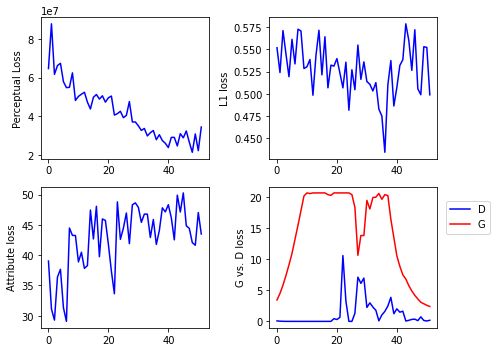

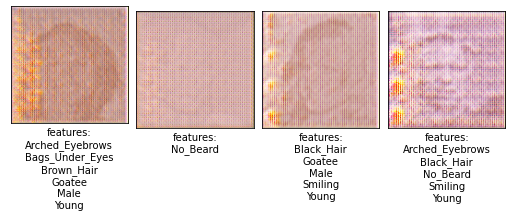

In [ ]:
plot = apply_plot(4)
instance.fit(memiter, iter, epochs=1, disc_iter=1, gen_iter=1 , callbacks=[plot])

In [ ]:
(img , label) = next(dataset())
img.shape, np.max(img[16]), np.min(img[16])

((32, 128, 128, 3), 1.0, -0.9607843)

In [ ]:
inpa = label[0]
targeta = label[1]

In [ ]:
out = instance.generator.predict(( np.array([img[0]]) , np.array([targeta - inpa])))

In [ ]:
out.shape

(1, 128, 128, 3)

In [ ]:
out = (undo_standardize(out[0]))

In [ ]:
out.shape , np.max(out) , np.min(out)

((128, 128, 3), 250.48871, 4.7251205)

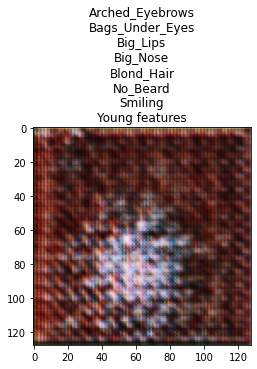

In [ ]:
seeOne(( out/255 , targeta), parseData.index2attr)

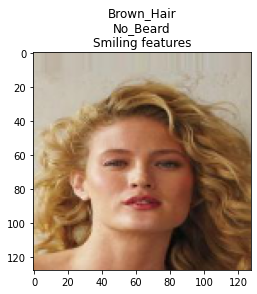

In [ ]:
seeOne((  (undo_standardize(img[16]))  / 255 , label[0]) , parseData.index2attr)